In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import torch
from sema_guidance import StableDiffusionFreeGuidancePipeline
# from sema_guidance import StableDiffusionFreeGuidancePipeline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn import init
from utils.guidance_functions import *
import argparse
from diffusers import LMSDiscreteScheduler, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler
from utils import *
from PIL import Image
torch.cuda.manual_seed_all(1234) 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'


/root/anaconda3/envs/free_guide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

print("Start Inference!")
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"
NUM_DDIM_STEPS = 50
pipe = StableDiffusionFreeGuidancePipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.unet = UNetDistributedDataParallel(pipe.unet, device_ids=[0]).cuda()
# pipe.vae = UNetDistributedDataParallel(pipe.vae, device_ids=[0,1,2]).cuda()
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2]).cuda()
# pipe.unet = pipe.unet.to(device)
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2,3,4], output_device=3).cuda()
# pipe.unet.config, pipe.unet.dtype, pipe.unet.attn_processors, pipe.unet.set_attn_processor = pipe.unet.module.config, pipe.unet.module.dtype, pipe.unet.module.attn_processors, pipe.unet.module.set_attn_processor
# pipe.unet.config, pipe.unet.dtype = pipe.unet.module.config, pipe.unet.module.dtype
pipe.unet = pipe.unet.module
pipe = pipe.to(device)

# pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config) # DDPMScheduler -> DDIMScheduler
pipe.scheduler.set_timesteps(NUM_DDIM_STEPS)

pipe.enable_attention_slicing()
torch.backends.cudnn.benchmark = True

Start Inference!


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Model loaded successfully!


cross_attention dimension
down_blocks：
4096 4096
1024 1024
256 256
mid：
64
up_block：
256 256 256
1024 1024 1024
4096 4096 4096
res activation
down_blocks：
layer1 (1,320,64,64)
layer2 (1,640,32,32)
layer3 (1,1280,16,16)
layer4 (1,1280,8,8)
up_block：
layer1 (1,1280,8,8)
layer2 (1,1280,16,16)
layer3 (1,640,32,32)
layer4 (1,320,64,64)

In [ ]:
seed = 13519 #int(torch.rand((1,)) * 100000) #13519
generator=torch.manual_seed(seed)
print(seed)

prompts = ["a photo of a dog", 
           "a photo of a corgi"]

object_to_edit = 'corgi'

guidance = partial(match_semantic_feature, position_weight=6.0, sem_weight=4.0, feature_weight=6.0) #feature_weight: 3.0
# move = partial(roll_shape, direction='up', factor=0.0)
# guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)
feature_layer = pipe.unet.up_blocks[-3].resnets[-1] #resnets: 0 1 2

img_path = './img/dog3.JPEG'
latents = get_ddim_latents(pipe, img_path, prompts[0], device)
init_latent = latents[-1]

image_list = pipe(prompts[1], prompts[0], obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=1500, feature_layer=feature_layer) 
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

In [8]:
seed = 13519 #int(torch.rand((1,)) * 100000) #13519
generator=torch.manual_seed(seed)
print(seed)

prompts = ["a photo of a dog in the river", 
           "a photo of a corgi in the river"]

object_to_edit = 'corgi'

guidance = partial(match_semantic_feature, position_weight=6.0, sem_weight=4.0, feature_weight=6.0) #feature_weight: 3.0
# move = partial(roll_shape, direction='up', factor=0.0)
# guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)
feature_layer = pipe.unet.up_blocks[-3].resnets[-1] #resnets: 0 1 2

img_path = './img/shepherd.png'
latents = get_ddim_latents(pipe, img_path, prompts[0], device)
init_latent = latents[-1]

image_list = pipe(prompts[1], prompts[0], obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=1500, feature_layer=feature_layer) 
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

13519


  0%|          | 0/50 [00:00<?, ?it/s]/workspace/Free-Guidance-Diffusion/utils/guidance_functions.py:188: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  flow_map = torch.stack([nearest_indices % (ori_feats.shape[3]), nearest_indices // (ori_feats.shape[3])], dim=0).float()


tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(4.26, device='cuda:0') tensor(0.41, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(5.57, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.14, device='cuda:0') tensor(3.76, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.69, device='cuda:0') tensor(2.68, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(6.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') t

  2%|▏         | 1/50 [00:04<03:55,  4.80s/it]

tensor(0.13, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.84, device='cuda:0') tensor(3.57, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.19, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(8.73, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.17, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(8.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.16, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(7.45, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(6.93, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tenso

  4%|▍         | 2/50 [00:10<04:02,  5.04s/it]

tensor(0.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.87, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.42, device='cuda:0') tensor(4.23, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.16, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.96, device='cuda:0') tensor(4.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(5.59, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.97, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') ten

  6%|▌         | 3/50 [00:14<03:54,  4.99s/it]

tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.36, device='cuda:0') tensor(3.65, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.94, device='cuda:0') tensor(4.30, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.79, device='cuda:0') tensor(3.68, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.40, device='cuda:0') tensor(3.80, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.00, device='cuda:0') tensor(3.53, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.15, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0

  8%|▊         | 4/50 [00:19<03:48,  4.97s/it]

tensor(0.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.64, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.13, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.45, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(5.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.67, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.38, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(

 10%|█         | 5/50 [00:24<03:44,  4.99s/it]

tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.26, device='cuda:0') tensor(3.88, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.13, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(5.01, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.73, device='cuda:0') tensor(4.26, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.40, device='cuda:0') tensor(3.80, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.16, device='cuda:0') tensor(3.74, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.82, device='cuda:0

 12%|█▏        | 6/50 [00:29<03:39,  4.98s/it]

tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.19, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.50, device='cuda:0') tensor(4.54, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.80, device='cuda:0') tensor(3.74, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(3.11, device='cuda:0') tensor(3.34, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.57, device='cuda:0') tensor(3.80, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.22, device='cuda:0

 14%|█▍        | 7/50 [00:34<03:35,  5.00s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.34, device='cuda:0') tensor(2.48, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.95, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.15, device='cuda:0') tensor(4.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.10, device='cuda:0') tensor(3.74, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.40, device='cuda:0') tensor(3.41, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.58, device='cuda:0

 16%|█▌        | 8/50 [00:39<03:30,  5.02s/it]

tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.23, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.76, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.45, device='cuda:0') tensor(3.64, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.17, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.43, device='cuda:0') tensor(3.93, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.27, device='cuda:0') t

 18%|█▊        | 9/50 [00:44<03:24,  4.99s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.32, device='cuda:0') tensor(2.22, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.54, device='cuda:0') tensor(3.28, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.31, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.68, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.01, device='cuda:0') t

 20%|██        | 10/50 [00:49<03:18,  4.97s/it]

tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.32, device='cuda:0') tensor(2.27, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.43, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.61, device='cuda:0') tensor(2.72, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(2.59, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.13, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.49, device='cuda:0') t

 22%|██▏       | 11/50 [00:55<03:18,  5.10s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.34, device='cuda:0') tensor(3.28, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 24%|██▍       | 12/50 [00:57<02:39,  4.21s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.61, device='cuda:0') tensor(2.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.19, device='cuda:0') tensor(4.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.61, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.70, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.41, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.09, device='cuda:0') t

 26%|██▌       | 13/50 [01:02<02:44,  4.44s/it]

tensor(0.12, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.79, device='cuda:0') tensor(2.68, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 28%|██▊       | 14/50 [01:04<02:16,  3.79s/it]

tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.89, device='cuda:0') tensor(2.48, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.03, device='cuda:0') tensor(2.43, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.03, device='cuda:0') tensor(2.66, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.09, device='cuda:0') tensor(3.37, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(4.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.41, device='cuda:0

 30%|███       | 15/50 [01:09<02:24,  4.14s/it]

tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.81, device='cuda:0') tensor(1.88, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 32%|███▏      | 16/50 [01:11<02:01,  3.58s/it]

tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(1.56, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.28, device='cuda:0') tensor(3.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.75, device='cuda:0') tensor(2.68, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.73, device='cuda:0') tensor(2.83, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.15, device='cuda:0') tensor(2.98, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.02, device='cuda:0

 34%|███▍      | 17/50 [01:16<02:12,  4.00s/it]

tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.44, device='cuda:0') tensor(1.69, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 36%|███▌      | 18/50 [01:19<01:59,  3.74s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0., device='cuda:0') tensor(3.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.75, device='cuda:0') tensor(3.66, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.08, device='cuda:0') tensor(3.18, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.47, device='cuda:0') tensor(2.83, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.49, device='cuda:0') tensor(2.71, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.22, device='cuda:0

 38%|███▊      | 19/50 [01:24<02:07,  4.11s/it]

tensor(0.09, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.92, device='cuda:0') tensor(1.35, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 40%|████      | 20/50 [01:27<01:47,  3.60s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.51, device='cuda:0') tensor(1.79, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.32, device='cuda:0') tensor(2.90, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.58, device='cuda:0') tensor(3.44, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.37, device='cuda:0') tensor(3.28, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.15, device='cuda:0') tensor(2.87, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.32, device='cuda

 42%|████▏     | 21/50 [01:32<01:57,  4.04s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.93, device='cuda:0') tensor(0.97, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 44%|████▍     | 22/50 [01:34<01:38,  3.53s/it]

tensor(0.10, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.07, device='cuda:0') tensor(1.86, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.28, device='cuda:0') tensor(2.24, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.47, device='cuda:0') tensor(3.54, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.55, device='cuda:0') tensor(3.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.73, device='cuda:0') tensor(3.29, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.88, device='cuda

 46%|████▌     | 23/50 [01:39<01:47,  3.99s/it]

tensor(0.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.76, device='cuda:0') tensor(1.27, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 48%|████▊     | 24/50 [01:42<01:30,  3.50s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.79, device='cuda:0') tensor(1.01, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.15, device='cuda:0') tensor(1.96, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.39, device='cuda:0') tensor(2.24, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.20, device='cuda:0') tensor(1.99, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.18, device='cuda:0') tensor(1.80, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.21, device='cuda

 50%|█████     | 25/50 [01:47<01:38,  3.95s/it]

tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.15, device='cuda:0') tensor(0.64, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 52%|█████▏    | 26/50 [01:49<01:23,  3.46s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(0.98, device='cuda:0') tensor(0.87, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.20, device='cuda:0') tensor(1.55, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.87, device='cuda:0') tensor(2.14, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.79, device='cuda:0') tensor(2.02, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.27, device='cuda:0') tensor(1.77, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.09, device='cuda

 54%|█████▍    | 27/50 [01:54<01:30,  3.92s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.08, device='cuda:0') tensor(0.57, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 56%|█████▌    | 28/50 [01:56<01:15,  3.45s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.54, device='cuda:0') tensor(0.87, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.67, device='cuda:0') tensor(1.70, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.25, device='cuda:0') tensor(1.91, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.27, device='cuda:0') tensor(1.70, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.54, device='cuda:0') tensor(1.59, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.38, device='cuda

 58%|█████▊    | 29/50 [02:01<01:22,  3.91s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.51, device='cuda:0') tensor(0.82, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 60%|██████    | 30/50 [02:04<01:08,  3.43s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.89, device='cuda:0') tensor(0.87, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.08, device='cuda:0') tensor(1.31, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.93, device='cuda:0') tensor(1.82, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.46, device='cuda:0') tensor(1.86, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.14, device='cuda:0') tensor(1.58, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.75, device='cuda

 62%|██████▏   | 31/50 [02:09<01:14,  3.90s/it]

tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.12, device='cuda:0') tensor(0.52, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 64%|██████▍   | 32/50 [02:11<01:01,  3.43s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.41, device='cuda:0') tensor(0.67, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.23, device='cuda:0') tensor(1.11, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.36, device='cuda:0') tensor(1.33, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.57, device='cuda:0') tensor(1.08, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.59, device='cuda:0') tensor(1.03, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.62, device='cuda

 66%|██████▌   | 33/50 [02:16<01:06,  3.90s/it]

tensor(0.07, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.92, device='cuda:0') tensor(0.44, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 68%|██████▊   | 34/50 [02:18<00:55,  3.44s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.40, device='cuda:0') tensor(0.76, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.56, device='cuda:0') tensor(0.96, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.25, device='cuda:0') tensor(1.01, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.20, device='cuda:0') tensor(1.15, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.58, device='cuda:0') tensor(1.00, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.54, device='cuda

 70%|███████   | 35/50 [02:23<00:59,  3.95s/it]

tensor(0.06, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.56, device='cuda:0') tensor(0.57, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


 72%|███████▏  | 36/50 [02:26<00:49,  3.53s/it]

tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(1.81, device='cuda:0') tensor(0.72, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.04, device='cuda:0') tensor(0.96, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.23, device='cuda:0') tensor(1.16, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.04, device='cuda:0') tensor(1.01, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.05, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.24, device='cuda:0') tensor(0.97, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.24, device='cuda

 76%|███████▌  | 38/50 [02:36<00:49,  4.16s/it]

tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.59, device='cuda:0') tensor(0.56, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.56, device='cuda:0') tensor(0.85, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.53, device='cuda:0') tensor(0.99, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.55, device='cuda:0') tensor(0.88, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.03, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.53, device='cuda:0') tensor(0.91, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.04, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>) tensor(2.53, device='cuda

 78%|███████▊  | 39/50 [02:46<00:46,  4.26s/it]


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 47.54 GiB total capacity; 21.94 GiB already allocated; 198.19 MiB free; 21.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [4]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompt = 'a photo of a donut and a shot of espresso on a table'
object_to_edit = 'donut'
objects = ['donut', 'espresso']
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/donut.png' 
latents = get_ddim_latents(pipe, img_path, prompt, device)
init_latents = latents[-1]
# init_latents = get_latents_from_image(pipe, img_path, device)

image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latents, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=3000)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

90293


  0%|          | 0/50 [00:06<?, ?it/s]


KeyboardInterrupt: 

72388


100%|██████████| 50/50 [03:53<00:00,  4.68s/it]


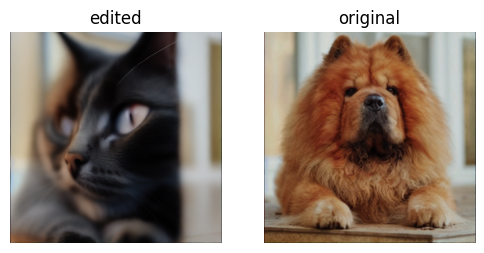

In [ ]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompts = ["a photo of a dog", 
           "a photo of a cat"]

object_to_edit = 'cat'
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/dog.png'
latents = get_ddim_latents(pipe, img_path, prompts[0], device)
init_latent = latents[-1]

image_list = pipe(prompts[1], prompts[0], obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=0)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

## Swapping word

In [ ]:
def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller

def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

NameError: name 'Dict' is not defined

In [ ]:
prompts = ['a photo of a dog',
           'a photo of a cat'
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('dog',), ('cat', )))
eq_params = {"words": ("cat",), "values": (2,)}

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")